# Deep Neural Network (DNN) for Jet Classification

This section implements a Deep Neural Network (DNN) using dense (fully connected) layers to classify jets as either QCD background or Higgs boson signal (H → bb̄). The input features are handcrafted jet-level variables, including summary statistics derived from per-constituent observables (e.g., mean track p<sub>T</sub>). Each jet is treated as a fixed-size feature vector by aggregating constituent information.

The DNN architecture includes:

Batch normalization for stable training

Dropout for regularization

ReLU activations in hidden layers

A final softmax layer for binary classification

Jets used in training are filtered with:

Mass cut: 40 GeV < M<sub>sd</sub> < 200 GeV

p<sub>T</sub> cut: 300 GeV < p<sub>T</sub> < 2000 GeV

Model performance is visualized using the ROC curve and quantified via the AUC metric.

In [1]:
# ============================================================
# Import required libraries and tools for data handling
# ============================================================

import fsspec_xrootd  # Enables xrootd file system access (e.g., remote ROOT files)
import uproot         # Reads ROOT files in Python
import awkward as ak  # Efficient handling of jagged arrays (used in HEP)
import numpy as np

# Custom utility functions for jet processing, image making, etc.
import utilities.utils as utils

# Load configuration variables (features, labels, etc.)
import yaml

# ============================================================
# TensorFlow/Keras setup
# ============================================================

# Force TensorFlow to run on CPU only
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)

# ============================================================
# Metrics and plotting
# ============================================================

from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep

# Use CMS-style plotting
plt.style.use(hep.style.ROOT)


In [2]:
# Load the definitions
with open('./utilities/definitions_bdt_dnn.yml', 'r') as file:
    definitions = yaml.load(file, Loader = yaml.FullLoader)

features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']

In [3]:
# ============================================================
# Set file paths for training and testing
# ============================================================

train_file_path = '/Users/sashibhusansahoo/Desktop/iop sem 1/Project Stuff/root_data/ntuple_merged_0.root'  # Path to training ROOT file
test_file_path  = '/Users/sashibhusansahoo/Desktop/iop sem 1/Project Stuff/root_data/ntuple_merged_0.root'  # Path to testing ROOT file

# ============================================================
# Load training data: features, labels, spectators
# ============================================================

feature_array, label_array, spec_array = utils.get_features_labels(
    train_file_path,
    features=features,         # List of input feature names
    spectators=spectators,     # List of spectator variables (e.g., mass, pT)
    labels=labels,             # List of target labels (e.g., Hbb, QCD)
    remove_mass_pt_window=True, # Apply pT and mass window cut
    entry_stop=20000        # Max number of events to read
)

# ============================================================
# Load testing data: features, labels, spectators
# ============================================================

feature_array_test, label_array_test, spectator_array_test = utils.get_features_labels(
    test_file_path,
    features=features,
    labels=labels,
    spectators=spectators,
    remove_mass_pt_window=True,
    entry_stop=5000          # Fewer entries for evaluation
)


In [4]:
# ============================================================
# Flatten nested/non-float features in training array
# ============================================================

for j in range(len(feature_array)):                     # Loop over each event
    for i in range(len(feature_array[j, :])):           # Loop over each feature
        if not isinstance(feature_array[j, i], float):  # If entry is not scalar float
            feature_array[j, i] = np.mean(feature_array[j, i])  # Replace with mean value

# ============================================================
# Flatten nested/non-float features in testing array
# ============================================================

for j in range(len(feature_array_test)):                        
    for i in range(len(feature_array_test[j, :])):              
        if not isinstance(feature_array_test[j, i], float):     
            feature_array_test[j, i] = np.mean(feature_array_test[j, i])  

# ============================================================
# Convert final arrays to float32 type
# ============================================================

feature_array = feature_array.astype(np.float32)
feature_array_test = feature_array_test.astype(np.float32)


In [5]:
# ============================================================
# DNN model for jet classification using Keras Functional API
# ============================================================

# Input layer: accepts flat feature vector of shape (nfeatures,)
inputs = Input(shape=(nfeatures,), name='input')

# Batch normalization to stabilize training
x = BatchNormalization(name='Bn_1')(inputs)

# Dropout for regularization (prevent overfitting)
x = Dropout(0.2)(x)

# First dense (fully connected) layer with ReLU activation
x = Dense(128, name='dense_1', activation='relu')(x)

# Second batch normalization layer
x = BatchNormalization(name='Bn_2')(x)

# Dropout again
x = Dropout(0.2)(x)

# Second dense layer
x = Dense(64, name='dense_2', activation='relu')(x)

# Third batch normalization layer
x = BatchNormalization(name='Bn_3')(x)

# Third dense layer
x = Dense(64, name='dense_3', activation='relu')(x)

# Final dropout
x = Dropout(0.2)(x)

# Output layer: softmax for multi-class classification (nlabels = number of classes)
outputs = Dense(nlabels, name='output', activation='softmax')(x)

# Build the model
dnn_model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and categorical cross-entropy loss
dnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
dnn_model.summary()


2025-07-11 11:01:37.416807: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-07-11 11:01:37.416829: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-11 11:01:37.416834: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-11 11:01:37.416849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-11 11:01:37.416856: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bn_1 (BatchNormalization)       │ (None, 42)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bn_2 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bn_3 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,986 (74.16 KB)

 Trainable params: 18,518 (72.34 KB)

 Non-trainable params: 468 (1.83 KB)

In [6]:
# ============================================================
# Define callbacks to monitor training and improve performance
# ============================================================

# Stop training if validation loss doesn't improve for 20 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=20             # Number of epochs to wait before stopping
)

# Reduce learning rate by a factor of 0.5 if val_loss plateaus for 5 epochs
reduce_lr = ReduceLROnPlateau(
    patience=5,             # Wait 5 epochs without improvement
    factor=0.5              # Reduce LR by half
)

# Save the best model based on validation loss
model_checkpoint = ModelCheckpoint(
    './trained_models/new_models/keras_model_best_dnn.keras',  # Path to save the model
    monitor='val_loss',         # Monitor validation loss
    save_best_only=True,        # Save only the best model
    save_weights_only=False     # Save full model (not just weights)
)

# Group all callbacks
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# ============================================================
# Train the DNN model
# ============================================================

history = dnn_model.fit(
    feature_array,            # Input features (shape: [n_samples, nfeatures])
    label_array,              # Target labels (one-hot encoded)
    batch_size=96,            # Mini-batch size
    epochs=100,               # Maximum number of epochs
    validation_split=0.15,    # Reserve 15% of data for validation
    shuffle=False,            # Do not shuffle data (preserve ordering)
    callbacks=callbacks,      # Use callbacks defined above
    verbose=0                 # Suppress training output (set to 1 or 2 to see logs)
)

# ============================================================
# Load the best model based on validation loss
# ============================================================

dnn_model = load_model('./trained_models/new_models/keras_model_best_dnn.keras')


2025-07-11 11:01:37.821529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


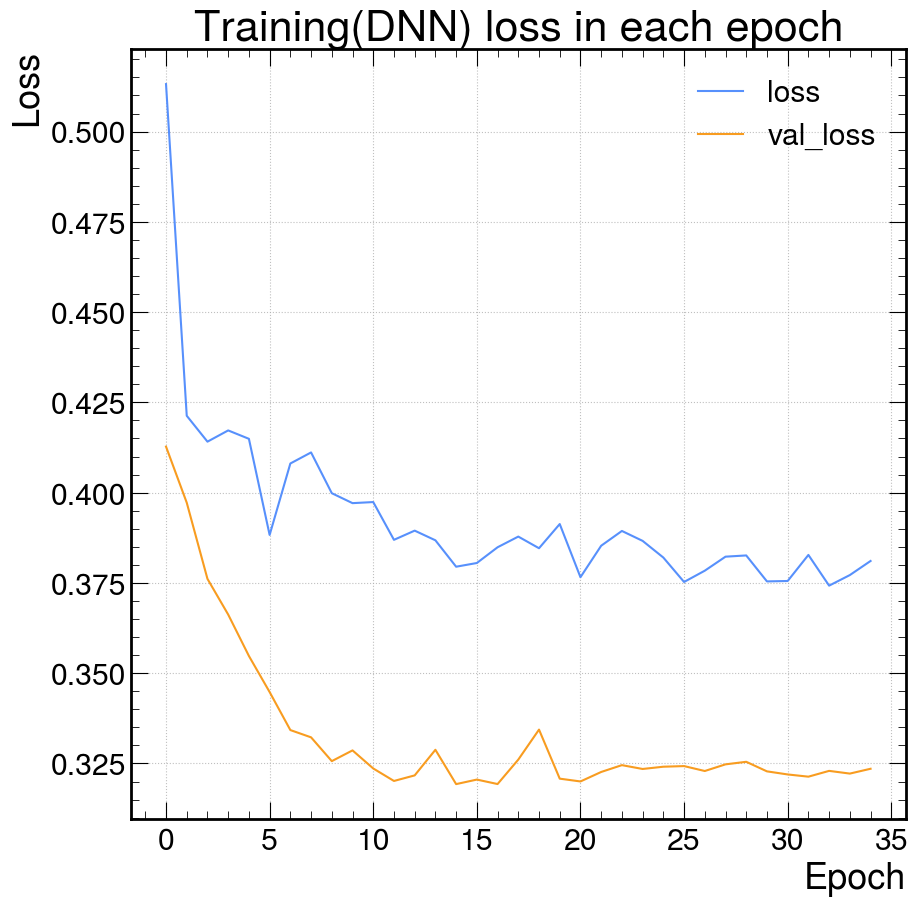

In [7]:
# Loss per epoch plot
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.title('Training(DNN) loss in each epoch')
plt.show()

In [8]:
# ============================================================
# Predict class probabilities on the test dataset
# ============================================================
predict_array_dnn = dnn_model.predict(feature_array_test)  # Shape: (n_samples, nlabels)

# ============================================================
# Convert softmax outputs to one-hot encoded class predictions
# ============================================================
def convert(data):
    """
    Convert predicted probabilities to one-hot encoded predictions.
    If prob(class 0) > prob(class 1) → [1, 0]
    Else → [0, 1]
    """
    conv_data = []
    for arr in data:
        if arr[0] > arr[1]:
            conv_data.append([1, 0])
        else:
            conv_data.append([0, 1])
    return np.array(conv_data)

# Apply conversion function to model predictions
predicted_classes = convert(predict_array_dnn)

# ============================================================
# Evaluate accuracy by comparing with ground truth labels
# ============================================================
accuracy = accuracy_score(
    predicted_classes[:, 1],     # Predicted class 1 labels
    label_array_test[:, 1]       # True class 1 labels
)

# ============================================================
# Print result
# ============================================================
print(f"By using the DNN classifier we obtain an accuracy of {accuracy*100:.2f}%")


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
By using the DNN classifier we obtain an accuracy of 86.99%


/Users/sashibhusansahoo/miniforge3/envs/hep/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8712 (\N{ELEMENT OF}) missing from font(s) TeX Gyre Heros.
  fig.canvas.print_figure(bytes_io, **kw)


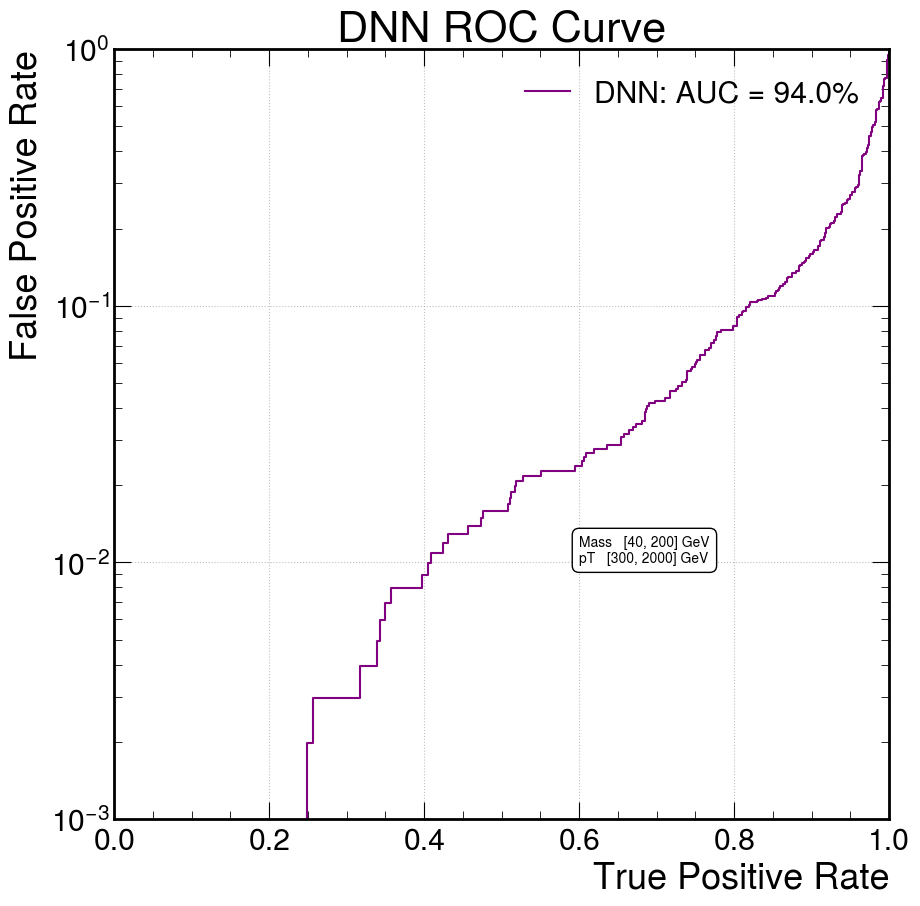

In [14]:
# ========================================
# Calculate FPR, TPR and ROC AUC for DNN
# ========================================
fpr_dnn, tpr_dnn, threshold_dnn = roc_curve(label_array_test[:, 1], predict_array_dnn[:, 1])
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# ========================================
# Plot the ROC curve
# ========================================
plt.figure()
plt.plot(tpr_dnn, fpr_dnn, label=f"DNN: AUC = {roc_auc_dnn*100:.1f}%", color="purple")

# Set plot to semi-log scale (for better visibility of low FPR)
plt.semilogy()
plt.xlim(0, 1)
plt.ylim(0.001, 1)
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('DNN ROC Curve')
plt.grid(True)
plt.legend(loc='upper right')

# ========================================
# Add box showing mass and pT cuts
# ========================================
cut_text = "Mass ∈ [40, 200] GeV\npT ∈ [300, 2000] GeV"
plt.gca().text(0.6, 0.01, cut_text,
               fontsize=10,
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.show()
